# **A - Data Wrangling**

In [126]:
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the Excel file
file_path = 'Manufacturing_Line_Productivity.xlsx'

# Load dimension tables
products_df = pd.read_excel(file_path, sheet_name='Products')
downtime_factors_df = pd.read_excel(file_path, sheet_name='Downtime factors')

# Load fact tables
line_productivity_df = pd.read_excel(file_path, sheet_name='Line productivity')
line_downtime_df = pd.read_excel(file_path, sheet_name='Line downtime')
# Check for missing values in each DataFrame
print("Missing values in Line Productivity:")
print(line_productivity_df.isnull().sum())

print("\nMissing values in Products:")
print(products_df.isnull().sum())

print("\nMissing values in Downtime Factors:")
print(downtime_factors_df.isnull().sum())

print("\nMissing values in Line Downtime:")
print(line_downtime_df.isnull().sum())

# Check for duplicates in each DataFrame
print("\nDuplicates in Line Productivity:")
print(line_productivity_df.duplicated().sum())

print("\nDuplicates in Products:")
print(products_df.duplicated().sum())

print("\nDuplicates in Downtime Factors:")
print(downtime_factors_df.duplicated().sum())

print("\nDuplicates in Line Downtime:")
print(line_downtime_df.duplicated().sum())

Missing values in Line Productivity:
Date          0
Product       0
Batch         0
Operator      0
Start Time    0
End Time      0
dtype: int64

Missing values in Products:
Product           0
Flavor            0
Size              0
Min batch time    0
dtype: int64

Missing values in Downtime Factors:
Factor            0
Description       0
Operator Error    0
dtype: int64

Missing values in Line Downtime:
Unnamed: 0          0
Downtime factor    38
Unnamed: 2         33
Unnamed: 3         36
Unnamed: 4         29
Unnamed: 5         35
Unnamed: 6         26
Unnamed: 7         27
Unnamed: 8         32
Unnamed: 9         37
Unnamed: 10        35
Unnamed: 11        35
Unnamed: 12        32
dtype: int64

Duplicates in Line Productivity:
0

Duplicates in Products:
0

Duplicates in Downtime Factors:
0

Duplicates in Line Downtime:
0


# **B - Data Preprocessing and preparation**

In [127]:
# Load the Line downtime sheet correctly
# Skip the first row and set the second row as the header
line_downtime_df = pd.read_excel(file_path, sheet_name='Line downtime', skiprows=1)

# Reset the index to make 'Batch' a regular column
line_downtime_df = line_downtime_df.rename(columns={'Unnamed: 0': 'Batch'})

# Data Cleaning and Transformation

# 1. Clean column names (remove spaces and convert to lowercase)
def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df


# 1. Combine 'Date' with 'Start Time' and 'End Time' to create proper datetime objects
line_productivity_df['Start Time'] = pd.to_datetime(
    line_productivity_df['Date'].astype(str) + ' ' + line_productivity_df['Start Time'].astype(str),
    errors='coerce'
)
line_productivity_df['End Time'] = pd.to_datetime(
    line_productivity_df['Date'].astype(str) + ' ' + line_productivity_df['End Time'].astype(str),
    errors='coerce'
)

# 2. Drop rows with invalid datetime values (NaT)
line_productivity_df = line_productivity_df.dropna(subset=['Start Time', 'End Time']).copy()  # Explicitly create a copy

# 3. Calculate duration in minutes using .loc to avoid SettingWithCopyWarning
line_productivity_df.loc[:, 'Duration'] = (
    (line_productivity_df['End Time'] - line_productivity_df['Start Time']).dt.total_seconds() / 60
)
# If duration is negative (spans midnight), add 1440 minutes (24 hours) to correct it
line_productivity_df.loc[:, 'Duration'] = line_productivity_df['Duration'].apply(
    lambda x: x if x >= 0 else x + 1440
)

# 4. Melt the downtime data to long format for easier analysis
downtime_long_df = pd.melt(
    line_downtime_df,
    id_vars=['Batch'],  # Use 'Batch' as the id_vars
    var_name='Downtime Factor',
    value_name='Downtime Duration'
)
downtime_long_df = downtime_long_df.dropna(subset=['Downtime Duration'])

# 5. Ensure consistent data types and format for merging
# Convert 'Downtime Factor' in downtime_long_df to match 'Factor' in downtime_factors_df
downtime_long_df['Downtime Factor'] = downtime_long_df['Downtime Factor'].astype(str)
downtime_factors_df['Factor'] = downtime_factors_df['Factor'].astype(str)

# 6. Merge downtime data with downtime factors
downtime_long_df = downtime_long_df.merge(
    downtime_factors_df,
    left_on='Downtime Factor',
    right_on='Factor',
    how='left'
)

# 7. Merge productivity data with product details
line_productivity_df = line_productivity_df.merge(products_df, on='Product', how='left')

# 8. Merge downtime data with productivity data
final_df = line_productivity_df.merge(
    downtime_long_df,
    on='Batch',
    how='left'
)
final_df['Downtime Duration'] = final_df['Downtime Duration'].fillna(0)
final_df['Downtime Factor'] = final_df['Downtime Factor'].fillna(0)
final_df['Description'] = final_df['Description'].fillna('No Downtime')  # Fill nulls in Description
final_df['Operator Error'] = final_df['Operator Error'].fillna('No')  # Fill nulls in Operator Error
final_df = final_df.drop(columns=['Factor'])

# Save the cleaned data to a new Excel file or CSV for further analysis
final_df.to_csv('cleaned_manufacturing_data.csv', index=False)

# **C - Analytical Questions**
## **C.1 - Production Overview**

**1 - What is the average duration of each batch?**

In [128]:
average_duration1 = final_df.groupby('Batch').agg(
    Duration=('Duration', 'mean'),
    Minbatchtime = ('Min batch time', 'first')  # or use another aggregation function like 'mean', 'sum', etc.
).reset_index()
average_duration1



,Batch,Duration,Minbatchtime
0,422111,135.0,60
1,422112,100.0,60
2,422113,110.0,60
3,422114,100.0,60
4,422115,84.0,60
5,422116,60.0,60
6,422117,75.0,60
7,422118,120.0,60
8,422119,85.0,60
9,422120,112.0,60


**2 - Which batches exceed the expected minimum batch time?**

In [129]:
exceeding_batches = final_df[final_df['Duration'] > final_df['Min batch time']]
# Select relevant columns for display
exceeding_batches = exceeding_batches[['Batch', 'Duration', 'Min batch time']]
exceeding_batches = exceeding_batches.drop_duplicates()
# Sort the DataFrame in ascending order by 'Duration' (or any other column)
exceeding_batches = exceeding_batches.sort_values(by='Duration', ascending=False)
exceeding_batches

,Batch,Duration,Min batch time
59,422147,205.0,98
56,422146,160.0,98
53,422144,152.0,98
0,422111,135.0,60
21,422123,133.0,60
62,422148,130.0,98
47,422140,123.0,60
55,422145,120.0,98
11,422118,120.0,60
51,422143,118.0,60


**3 - How Many Batches were Produced Per Day?**

In [130]:
# Convert 'Date' column to datetime (if not already in datetime format)
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Remove duplicate batches based on the 'Batch' column
final_df = final_df.drop_duplicates(subset='Batch')

# Group by 'Date' and count the number of batches produced each day
batches_per_day = final_df.groupby('Date')['Batch'].count().reset_index()

# Rename the columns for clarity
batches_per_day.columns = ['Date', 'Batches Produced']

print(batches_per_day)

        Date  Batches Produced
0 2024-08-29                 7
1 2024-08-30                12
2 2024-08-31                 7
3 2024-09-02                11
4 2024-09-03                 1


**4 - Number of Batches per Product**

In [131]:
# Assuming 'final_df' is your DataFrame and 'product' is the column containing product names
product_batch_counts = final_df['Product'].value_counts()

# Convert the Series to a list of tuples (product, count) for easier readability
batches_per_product = list(product_batch_counts.items())

# Print the result
print("Number of batches per product (ordered descending):")
for product, count in batches_per_product:
    print(f"{product}: {count} batches")

Number of batches per product (ordered descending):
CO-600: 15 batches
RB-600: 7 batches
LE-600: 6 batches
CO-2L: 5 batches
DC-600: 4 batches
OR-600: 1 batches


**5 - How does batch duration vary by product type ?**

In [132]:
# Calculate total duration and number of batches for each product
product_stats = final_df.groupby('Product').agg(
    Total_Duration=('Duration', 'sum'),  # Total duration for each product
    Number_of_Batches=('Duration', 'count')  # Number of batches for each product
).reset_index()

# Calculate average duration per batch for each product
product_stats['Average_Duration_Per_Batch'] = product_stats['Total_Duration'] / product_stats['Number_of_Batches']

# Rename columns for clarity
product_stats.columns = ['Product', 'Total Duration (minutes)', 'Number of Batches', 'Average Duration Per Batch (minutes)']
product_stats

,Product,Total Duration (minutes),Number of Batches,Average Duration Per Batch (minutes)
0,CO-2L,767.0,5,153.400000
1,CO-600,1394.0,15,92.933333
2,DC-600,355.0,4,88.750000
3,LE-600,529.0,6,88.166667
4,OR-600,135.0,1,135.000000
5,RB-600,678.0,7,96.857143


**6 - How does batch duration vary by flavor?**

In [133]:
# Calculate total duration and number of batches for each flavor
flavor_stats = final_df.groupby('Flavor').agg(
    Total_Duration=('Duration', 'sum'),  # Total duration for each flavor
    Number_of_Batches=('Duration', 'count')  # Number of batches for each flavor
).reset_index()

# Calculate average duration per batch for each flavor
flavor_stats['Average_Duration_Per_Batch'] = flavor_stats['Total_Duration'] / flavor_stats['Number_of_Batches']

# Rename columns for clarity
flavor_stats.columns = ['Flavor', 'Total Duration (minutes)', 'Number of Batches', 'Average Duration Per Batch (minutes)']
flavor_stats

,Flavor,Total Duration (minutes),Number of Batches,Average Duration Per Batch (minutes)
0,Cola,2161.0,20,108.050000
1,Diet Cola,355.0,4,88.750000
2,Lemon lime,529.0,6,88.166667
3,Orange,135.0,1,135.000000
4,Root Berry,678.0,7,96.857143


**7 - What is the production time per per shift (depends on the start time)**

In [134]:
# Convert 'start time' and 'end time' to datetime
final_df['Start Time'] = pd.to_datetime(final_df['Start Time'])
final_df['End Time'] = pd.to_datetime(final_df['End Time'])

# Extract date and hour for shift determination
final_df['Date'] = final_df['Start Time'].dt.date
final_df['Hour'] = final_df['Start Time'].dt.hour
def determine_shift(hour):
    if 8 <= hour < 15:  # Morning Shift (6 AM to 2 PM)
        return 'Morning'
    elif 15 <= hour < 23:  # Afternoon Shift (2 PM to 10 PM)
        return 'Afternoon'
    else:  # Night Shift (23 PM to 8 AM)
        return 'Night'

# Apply the shift determination
final_df['Shift'] = final_df['Hour'].apply(determine_shift)
# Count the number of batches completed per shift
batches_per_shift = final_df.groupby(['Date', 'Shift']).size().reset_index(name='Batch Count')

# Calculate the total batches for each shift
total_batches_per_shift = batches_per_shift.groupby('Shift')['Batch Count'].sum().reset_index()

# Identify the shift with the highest number of batches completed
max_batches_shift = total_batches_per_shift.loc[total_batches_per_shift['Batch Count'].idxmax()]

# Display the results
print("Total Batches Completed by Shift:")
print(total_batches_per_shift)
print(f"\nShift with the Highest Number of Batches Completed: {max_batches_shift['Shift']} with {max_batches_shift['Batch Count']} batches.")

Total Batches Completed by Shift:
       Shift  Batch Count
0  Afternoon           14
1    Morning           15
2      Night            9

Shift with the Highest Number of Batches Completed: Morning with 15 batches.


**8 - Which product has the longest/shortest average batch duration?**

In [135]:
# Calculate average downtime duration by product (correct approach)
avg_duration_by_product = final_df.groupby('Product')['Downtime Duration'].sum().reset_index()

# Find product with longest and shortest average duration
longest_duration_product = avg_duration_by_product.loc[avg_duration_by_product['Downtime Duration'].idxmax()]
shortest_duration_product = avg_duration_by_product.loc[avg_duration_by_product['Downtime Duration'].idxmin()]

# Display the results
print("Product with Longest Average Downtime Duration:")
print(longest_duration_product)

print("\nProduct with Shortest Average Downtime Duration:")
print(shortest_duration_product)

Product with Longest Average Downtime Duration:
Product              CO-600
Downtime Duration     316.0
Name: 1, dtype: object

Product with Shortest Average Downtime Duration:
Product              OR-600
Downtime Duration      60.0
Name: 4, dtype: object


**9 - What is the total downtime for each batch?**

In [136]:
# Total downtime per batch
total_downtime_per_batch = final_df.groupby('Batch')["Downtime Duration"].sum().reset_index()
print("Total Downtime per Batch:")
print(total_downtime_per_batch)

# Top 5 worst-performing batches
print("\nTop 5 Worst Batches by Downtime:")
print(total_downtime_per_batch.sort_values("Downtime Duration", ascending=False).head(5))


Total Downtime per Batch:
     Batch  Downtime Duration
0   422111               60.0
1   422112               20.0
2   422113               50.0
3   422114               25.0
4   422115               24.0
5   422116                0.0
6   422117               10.0
7   422118               14.0
8   422119               25.0
9   422120               20.0
10  422121               15.0
11  422122               25.0
12  422123               43.0
13  422124               20.0
14  422125               10.0
15  422126               44.0
16  422127               23.0
17  422128               22.0
18  422129               15.0
19  422130               20.0
20  422131               20.0
21  422132                0.0
22  422133               20.0
23  422134               30.0
24  422135               30.0
25  422136                0.0
26  422137               30.0
27  422138               20.0
28  422139               20.0
29  422140               50.0
30  422141                7.0
31  422142    

**10 - How does batch size impact production time?**

In [137]:
# Group by Batch size and calculate the average production duration
batch_size_impact = final_df.groupby('Size').agg({'Duration': 'mean'}).reset_index()

# Rename columns for clarity
batch_size_impact.columns = ['Batch Size', 'Average Production Time (minutes)']

# Display the result
print(batch_size_impact)

  Batch Size  Average Production Time (minutes)
0        2 L                         153.400000
1     600 ml                          93.666667


**11 - What is the Number of Batches?**

In [138]:
num_patches = final_df['Batch'].nunique()  # Replace 'PatchID' with the actual column name
print(f'Number of unique patches: {num_patches}')

Number of unique patches: 38


## **C.2 - Operator Overview**

**1 - What is the total production time per operator?**

In [139]:
# If duration is negative, add 24 hours to correct it (since it spans across midnight)
final_df['Duration'] = final_df['Duration'].apply(lambda x: x if x >= 0 else x + 24)

#Group by 'Operator' and calculate the total production time
total_time_per_operator = final_df.groupby('Operator')['Duration'].sum().reset_index()

# Rename the columns for clarity
total_time_per_operator.columns = ['Operator', 'Total Production Time']

print(total_time_per_operator)

  Operator  Total Production Time
0  Charlie                 1158.0
1      Dee                 1030.0
2   Dennis                  820.0
3      Mac                  850.0


**2 - Are there patterns in downtime based on the time of day, product, or operator?**

In [140]:
# Create 'Day of Week' column
final_df['Day of Week'] = final_df['Start Time'].dt.day_name()  # Extract day of the week from 'Start Time'

# Group by day of the week and count downtime occurrences
downtime_by_day = final_df[final_df['Downtime Duration'] > 0].groupby('Day of Week')['Batch'].count().reset_index(name='Downtime Count')

# Total downtime by hour
downtime_by_hour = final_df.groupby('Hour')['Downtime Duration'].sum().reset_index()
downtime_by_hour.columns = ['Hour', 'Total Downtime (minutes)']

# Total downtime by product
downtime_by_product = final_df.groupby('Product')['Downtime Duration'].sum().reset_index()
downtime_by_product.columns = ['Product', 'Total Downtime (minutes)']

# Total downtime by operator
downtime_by_operator = final_df.groupby('Operator')['Downtime Duration'].sum().reset_index()
downtime_by_operator.columns = ['Operator', 'Total Downtime (minutes)']

# Sort results
downtime_by_day = downtime_by_day.sort_values(by='Downtime Count', ascending=False)

# Display the results
print("Total Downtime by Day:")
print(downtime_by_day)

print("\nTotal Downtime by Hour:")
print(downtime_by_hour)

print("\nTotal Downtime by Product:")
print(downtime_by_product)

print("\nTotal Downtime by Operator:")
print(downtime_by_operator)

Total Downtime by Day:
  Day of Week  Downtime Count
0      Friday              12
1      Monday              11
3    Thursday               6
2    Saturday               5
4     Tuesday               1

Total Downtime by Hour:
    Hour  Total Downtime (minutes)
0      1                      30.0
1      2                      20.0
2      4                      34.0
3      5                      50.0
4      6                      25.0
5      7                      47.0
6      8                      30.0
7      9                      35.0
8     10                      65.0
9     11                      80.0
10    12                     103.0
11    14                      92.0
12    15                      60.0
13    16                      30.0
14    17                      69.0
15    18                      23.0
16    19                      41.0
17    20                      22.0
18    21                      10.0
19    22                      40.0

Total Downtime by Product:
  Product

**3 - Which operator has the highest/lowest productivity based on batch duration?**

In [141]:
# Calculate average duration per operator
avg_duration_by_operator = final_df.groupby('Operator')['Duration'].sum().reset_index()

# Calculate productivity (inverse of average duration)
avg_duration_by_operator['Productivity'] = 1 / avg_duration_by_operator['Duration']

# Find operator with highest and lowest productivity
highest_productivity_operator = avg_duration_by_operator.loc[avg_duration_by_operator['Productivity'].idxmax()]
lowest_productivity_operator = avg_duration_by_operator.loc[avg_duration_by_operator['Productivity'].idxmin()]

# Display the results
print("Operator with Highest Productivity:")
print(highest_productivity_operator)

print("\nOperator with Lowest Productivity:")
print(lowest_productivity_operator)

Operator with Highest Productivity:
Operator         Dennis
Duration          820.0
Productivity    0.00122
Name: 2, dtype: object

Operator with Lowest Productivity:
Operator         Charlie
Duration          1158.0
Productivity    0.000864
Name: 0, dtype: object


## **C.3 - Downtime Factors**

**1 - What are the most frequent and severe downtime factors (e.g., machine failure, operator errors)?**

In [142]:
# Calculate the frequency of each downtime factor, split by Operator Error
downtime_frequency = final_df.groupby(['Description', 'Operator Error']).size().reset_index(name='Frequency')

# Calculate total downtime for each factor, split by Operator Error
total_downtime_by_factor = final_df.groupby(['Description', 'Operator Error'])['Downtime Duration'].sum().reset_index()
total_downtime_by_factor.columns = ['Description', 'Operator Error', 'Total Downtime (minutes)']

# Merge frequency and total downtime data
downtime_summary = pd.merge(downtime_frequency, total_downtime_by_factor, on=['Description', 'Operator Error'])

# Sort the summary by frequency and total downtime
downtime_summary = downtime_summary.sort_values(by=['Frequency', 'Total Downtime (minutes)'], ascending=False)

# Display the results
print("Downtime Summary by Factor and Operator Error:")
downtime_summary

Downtime Summary by Factor and Operator Error:


,Description,Operator Error,Frequency,Total Downtime (minutes)
3,Inventory shortage,No,9,225.0
6,Machine adjustment,Yes,7,217.0
0,Batch change,Yes,5,160.0
7,Machine failure,No,4,90.0
8,No Downtime,No,3,0.0
1,Batch coding error,Yes,2,74.0
5,Labeling error,No,2,42.0
10,Product spill,Yes,2,42.0
9,Other,No,2,22.0
2,Calibration error,Yes,1,24.0


**2 - Is there a correlation between batch duration and downtime?**

In [143]:
# Group by Batch and calculate total downtime and average production duration
downtime_summary = final_df.groupby('Batch').agg({
    'Downtime Duration': 'sum',
    'Duration': 'mean'
}).reset_index()

# Rename columns for clarity
downtime_summary.columns = ['Batch', 'Total Downtime (minutes)', 'Average Production Duration (minutes)']

# Calculate the correlation
correlation = downtime_summary['Total Downtime (minutes)'].corr(downtime_summary['Average Production Duration (minutes)'])

# Display the summary and correlation
print(downtime_summary)
print(f'Correlation between Total Downtime and Average Production Duration: {correlation}')

     Batch  Total Downtime (minutes)  Average Production Duration (minutes)
0   422111                      60.0                                  135.0
1   422112                      20.0                                  100.0
2   422113                      50.0                                  110.0
3   422114                      25.0                                  100.0
4   422115                      24.0                                   84.0
5   422116                       0.0                                   60.0
6   422117                      10.0                                   75.0
7   422118                      14.0                                  120.0
8   422119                      25.0                                   85.0
9   422120                      20.0                                  112.0
10  422121                      15.0                                   75.0
11  422122                      25.0                                   85.0
12  422123  

**3 - What is the overall efficiency of the manufacturing line (productive time vs. downtime)?**

In [149]:
# Calculate total productive time (only one entry per unique Batch)
total_productive_time = final_df.groupby('Batch')['Duration'].first().sum()

# Calculate total downtime
total_downtime = final_df['Downtime Duration'].sum()

# Calculate overall efficiency
efficiency = (total_downtime/total_productive_time) * 100 if total_downtime > 0 else 0
overall_efficiency = 100 - efficiency

# Display the results
print(f"Total Productive Time (minutes): {total_productive_time:.2f}")
print(f"Total Downtime (minutes): {total_downtime:.2f}")
print(f"Overall Production Efficiency of the Manufacturing Line: {overall_efficiency:.2f}%")

Total Productive Time (minutes): 3858.00
Total Downtime (minutes): 906.00
Overall Production Efficiency of the Manufacturing Line: 76.52%


# **D - Exploratory Data Analysis**

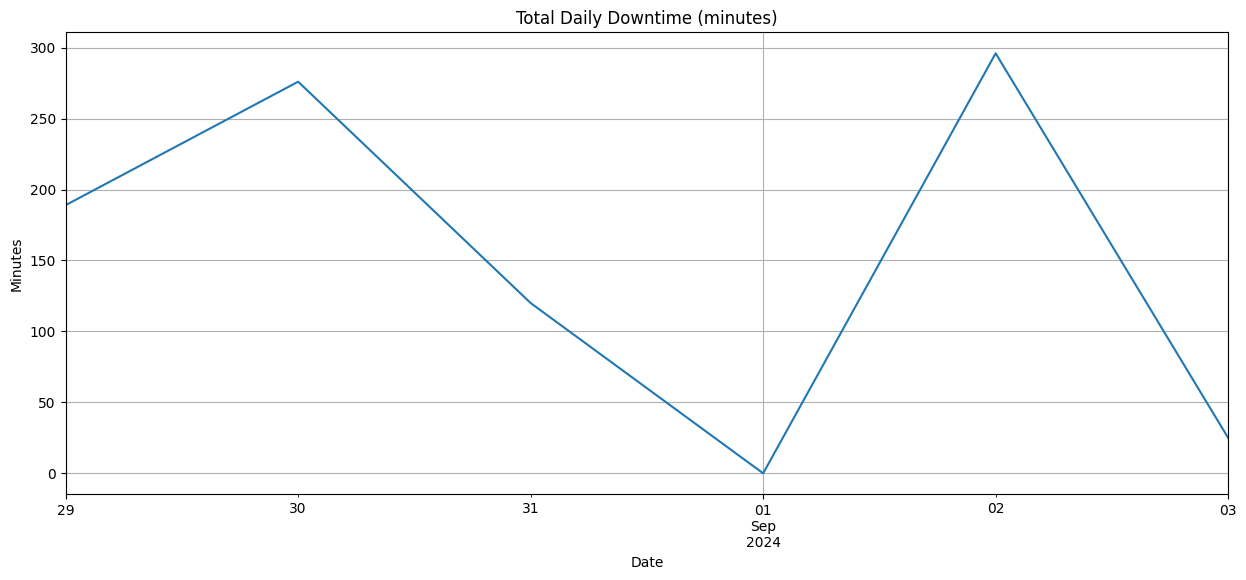

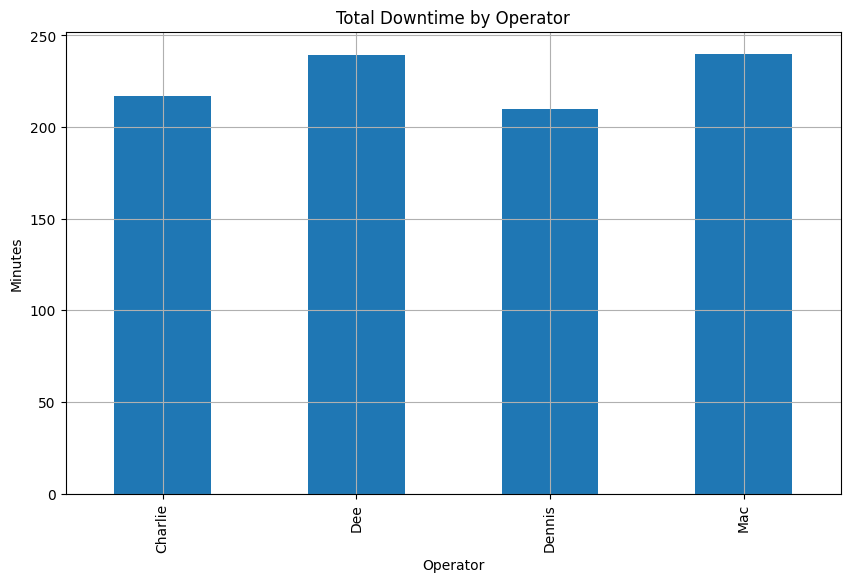

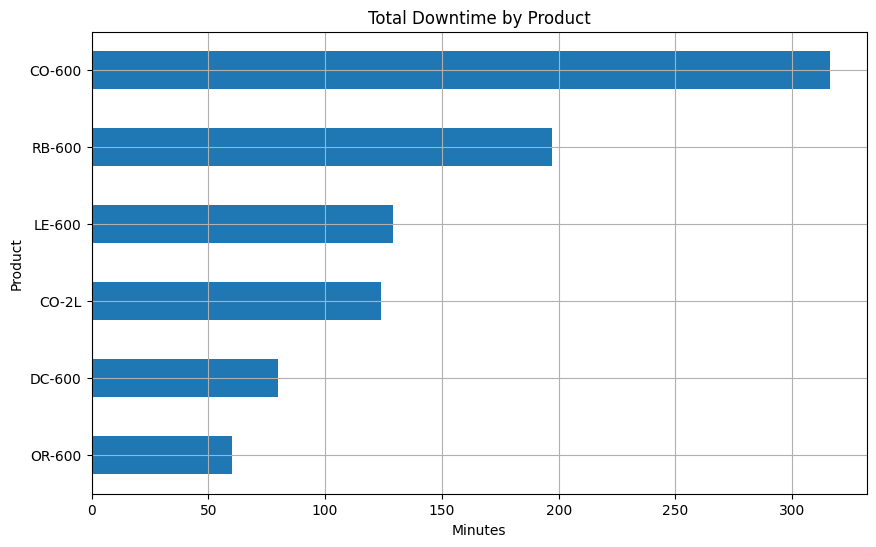

In [145]:
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.set_index('Date', inplace=True)

# Total Daily Downtime
plt.figure(figsize=(15, 6))
final_df.resample('D')['Downtime Duration'].sum().plot(title='Total Daily Downtime (minutes)')
plt.ylabel('Minutes')
plt.grid(True)  # Add grid lines
plt.show()

# Downtime by operator
plt.figure(figsize=(10, 6))
final_df.groupby('Operator')['Downtime Duration'].sum().plot(kind='bar')
plt.title('Total Downtime by Operator')
plt.ylabel('Minutes')
plt.grid(True)  # Add grid lines
plt.show()

# Downtime by product
plt.figure(figsize=(10, 6))
final_df.groupby('Product')['Downtime Duration'].sum().sort_values().plot(kind='barh')
plt.title('Total Downtime by Product')
plt.xlabel('Minutes')
plt.grid(True)  # Add grid lines
plt.show()

# **E - Manufacturing Productivity and Downtime Forecasting Analysis**

**1. Time Series Decomposition**

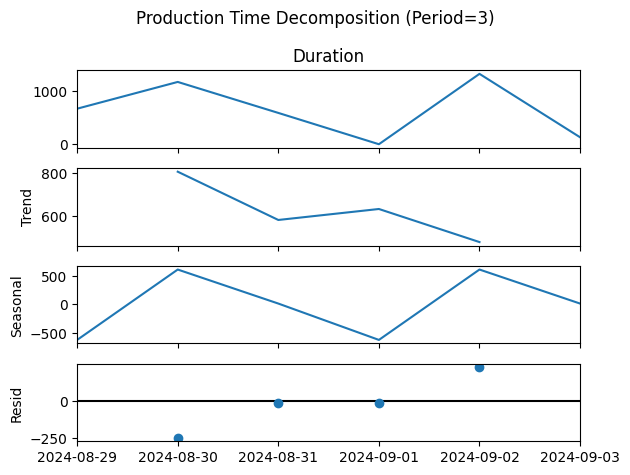

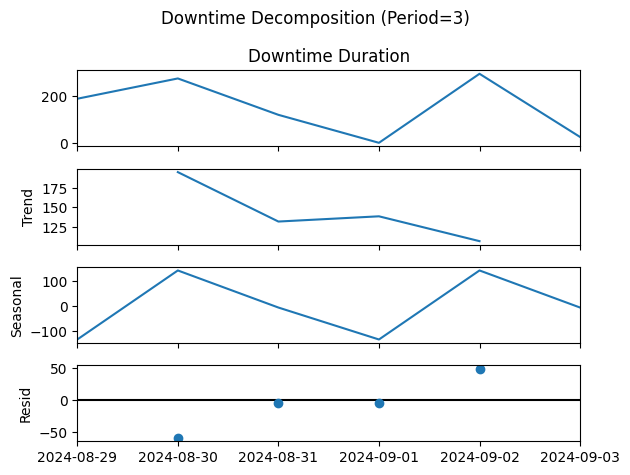

In [146]:
# --- Extract Date from Start Time ---
final_df['Date'] = pd.to_datetime(final_df['Start Time']).dt.date
final_df['Date'] = pd.to_datetime(final_df['Date'])  # ensure it's datetime format
final_df.set_index('Date', inplace=True)

# --- Check required columns ---
required_columns = ['Duration', 'Downtime Duration']
for col in required_columns:
    if col not in final_df.columns:
        raise KeyError(f"'{col}' column not found in final_df")

# --- Resample to daily totals ---
daily_duration = final_df['Duration'].resample('D').sum().dropna()
daily_downtime = final_df['Downtime Duration'].resample('D').sum().dropna()

# --- Automatically pick a safe period for decomposition ---
min_obs = min(len(daily_duration), len(daily_downtime))
period = 7 if min_obs >= 14 else max(2, min_obs // 2)

# --- Decompose Production Duration ---
result_duration = seasonal_decompose(daily_duration, model='additive', period=period)
result_duration.plot()
plt.suptitle(f'Production Time Decomposition (Period={period})')
plt.tight_layout()
plt.show()

# --- Decompose Downtime Duration ---
result_downtime = seasonal_decompose(daily_downtime, model='additive', period=period)
result_downtime.plot()
plt.suptitle(f'Downtime Decomposition (Period={period})')
plt.tight_layout()
plt.show()

**2. SARIMA model for production time forecasting**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

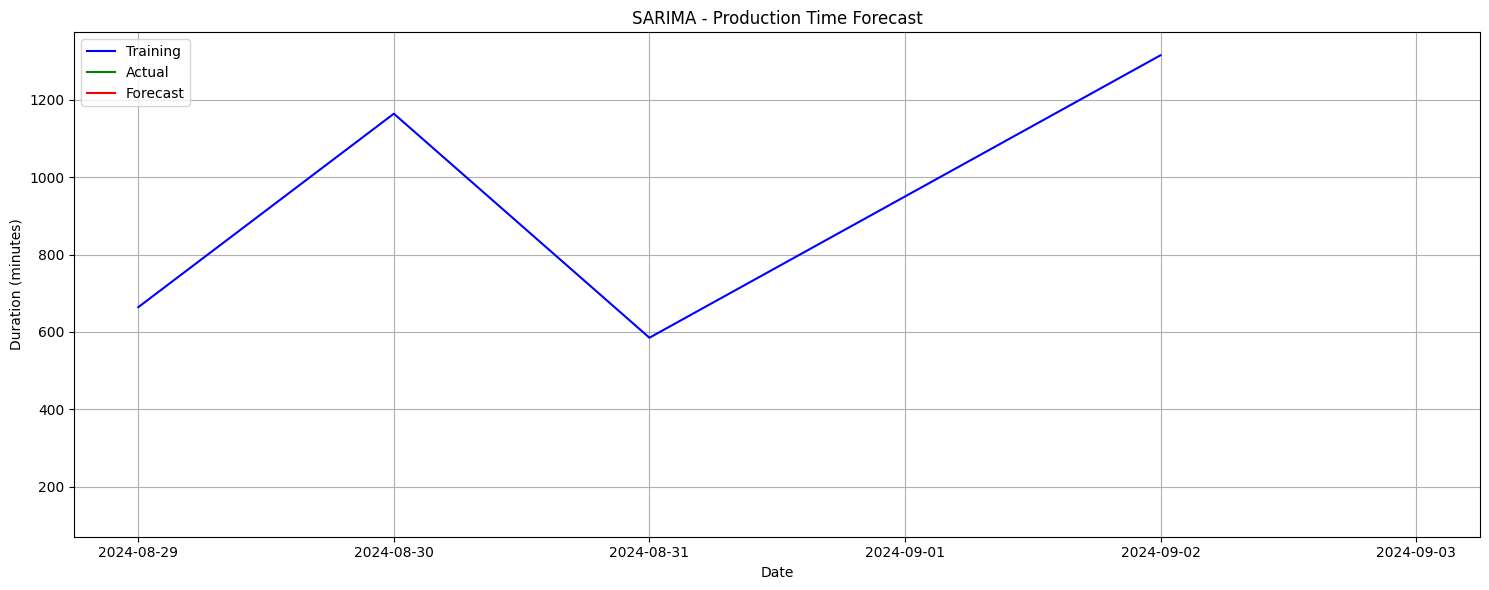

SARIMA Production Time RMSE: 1185.00 minutes


In [147]:
# --- Prepare the data (ensure datetime index) ---
# If not already done:
final_df['Date'] = pd.to_datetime(final_df['Start Time']).dt.date
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.set_index('Date', inplace=True)

# --- Aggregate to daily level ---
daily_data = final_df.resample('D').agg({
    'Duration': 'sum',
    'Downtime Duration': 'sum'
}).fillna(0)

# --- Ensure no missing or zero-only rows ---
daily_data = daily_data[daily_data['Duration'] > 0]  # Filter days with no production

# --- Train/test split ---
train_size = int(len(daily_data) * 0.8)
train, test = daily_data.iloc[:train_size], daily_data.iloc[train_size:]

# --- Fit SARIMA model on 'Duration' ---
sarima_duration = SARIMAX(train['Duration'],
                          order=(1, 1, 1),
                          seasonal_order=(1, 1, 1, 7),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

sarima_duration_fit = sarima_duration.fit(disp=False)

# --- Forecast for the test period ---
duration_forecast = sarima_duration_fit.forecast(steps=len(test))

# --- Plotting ---
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['Duration'], label='Training', color='blue')
plt.plot(test.index, test['Duration'], label='Actual', color='green')
plt.plot(test.index, duration_forecast, label='Forecast', color='red')
plt.title('SARIMA - Production Time Forecast')
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Evaluate model ---
rmse = sqrt(mean_squared_error(test['Duration'], duration_forecast))
print(f'SARIMA Production Time RMSE: {rmse:.2f} minutes')

**3. Prophet for downtime forecasting**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdwkb35a/gc2pjds1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdwkb35a/aw7kqdnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70280', 'data', 'file=/tmp/tmptdwkb35a/gc2pjds1.json', 'init=/tmp/tmptdwkb35a/aw7kqdnx.json', 'output', 'file=/tmp/tmptdwkb35a/prophet_modelka3rvib_/prophet_model-20250410001556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO

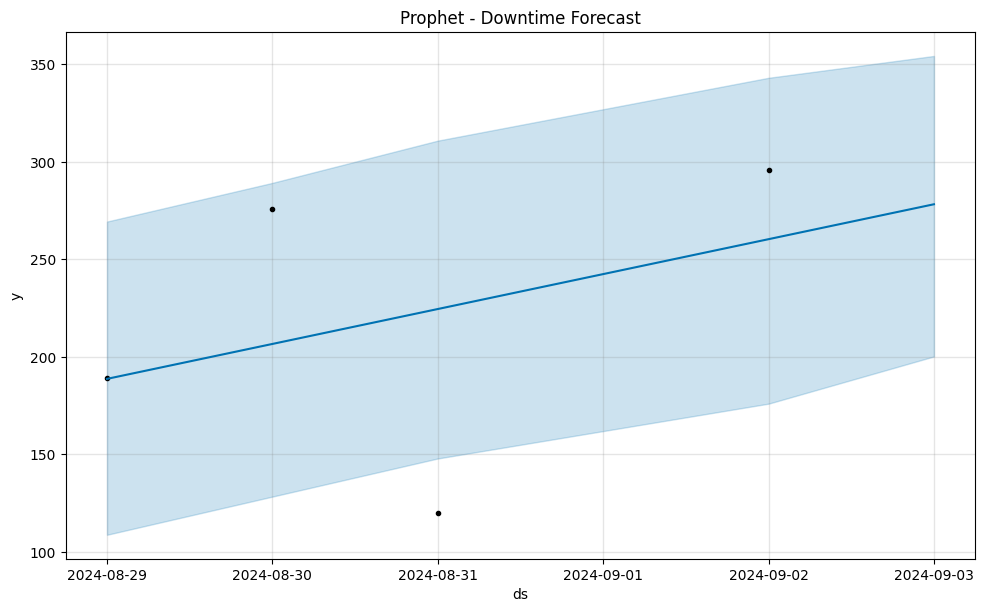

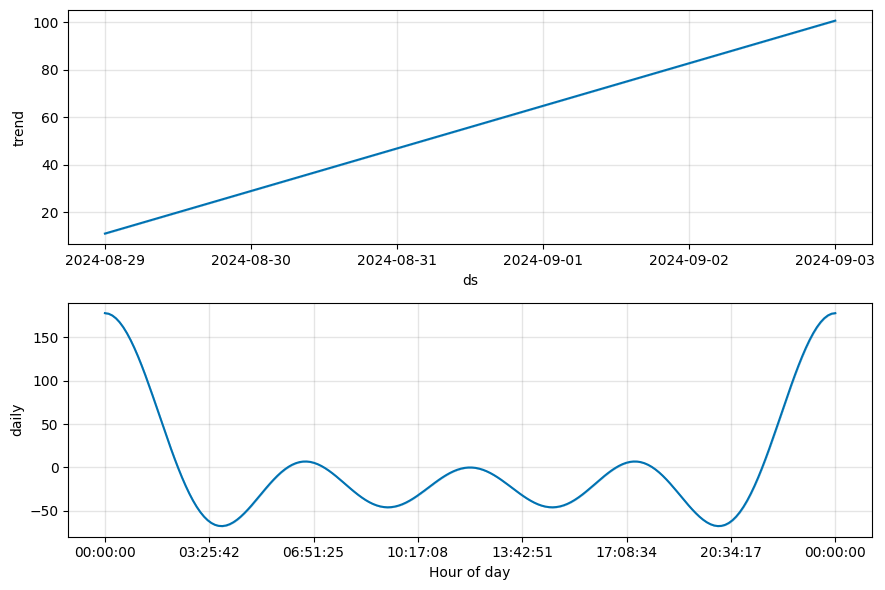

Prophet Downtime RMSE: 253.28 minutes


In [148]:
# Prepare data for Prophet
downtime_df = daily_data['Downtime Duration'].reset_index()
downtime_df.columns = ['ds', 'y']

# Split into train and test
prophet_train = downtime_df.iloc[:train_size]
prophet_test = downtime_df.iloc[train_size:]

# Fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(prophet_train)

# Create future dataframe and forecast
future = model.make_future_dataframe(periods=len(prophet_test))
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title('Prophet - Downtime Forecast')
plt.show()

# Plot components
fig = model.plot_components(forecast)
plt.show()

# Calculate RMSE
prophet_forecast = forecast.iloc[-len(prophet_test):]['yhat']
rmse = sqrt(mean_squared_error(prophet_test['y'], prophet_forecast))
print(f'Prophet Downtime RMSE: {rmse:.2f} minutes')